In [1]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import *
%matplotlib inline

In [4]:
img = Image.open("Images_starfish_blur.png")

In [7]:
# Store the image's width and height for later use. 
imgWidth = img.size[0]
imgHeight = img.size[1]
# We're going to use 7 features to segment
# This is an experimental choice.
# Choosing and normalising features can be a matter of experimentation.
numFeatures = 7
Z = np.ndarray(shape=(imgWidth * imgHeight, numFeatures), dtype = float)
Z = np.float32(Z)
for y in tqdm(range(0, imgHeight), ascii=True):
    for x in range(0, imgWidth):
        xy = (x, y)
        rgb = img.getpixel(xy)
        Z[x + y * imgWidth, 0] = rgb[0]           # blue
        Z[x + y * imgWidth, 1] = rgb[1]           # green
        Z[x + y * imgWidth, 2] = rgb[2]           # red
        # Experimentally, reduce the influence of the x,y components by dividing them by 10
        Z[x + y * imgWidth, 3] = x / 10           # x
        Z[x + y * imgWidth, 4] = y / 10           # y 
        Z[x + y * imgWidth, 5] = rgb[2] - rgb[0]  # red - blue
        Z[x + y * imgWidth, 6] = rgb[2] - rgb[1]  # red - green
# We need a second copy of our initial vector
# for OpenCV's K-means implementation.
Z2 = Z.copy()


100%|##########| 960/960 [00:03<00:00, 252.87it/s]


In [8]:
# So, k = 2
K = 2

# Create our cluster centers.

# clusterCenter is an arrangement of 'K' vectors
# each vector 'contains' our 7 columns or features that we described 
# in the preceding code block.
# For example, eventually, clusterCenters[0][0] will contain
# the mean of the 'blue's in cluster 0 and clusterCenters[0][1] will
# contain the mean of the 'red's in cluster 0, etc.
clusterCenters = np.ndarray(shape=(K,numFeatures))
# Initialise each element of both of our vectors 
# to rand values (each random number being between the max'es & mins of that feature in Z)
maxVals = np.amax(Z)
minVals = np.amin(Z)
for i, _ in enumerate(clusterCenters):
        clusterCenters[i] = np.random.uniform(minVals, maxVals, numFeatures)

# So now we have created our cluster Centers and initialized each clusterCenter's vector
# Let's create a data vector with an integer to represent whatever cluster a pixel belongs to. 
# We need one entry for each pixel - so that's a total of imgWidth * imgHeight's entries.
pixelClusterMembership = np.ndarray(shape=(imgWidth * imgHeight), dtype = int)

In [11]:
iterations = 10

# For each iteration:
for iteration in tqdm(range(iterations), ascii=True):
    # Part 1: Set each pixel to its cluster
    
    # use numpy to efficiently subtract both cluster 
    # center's vectors from all of the vectors representing
    # the pixels in the image.
    distances = Z[:,None,:] - clusterCenters[None,:,:]
    
    # Square every element in distances
    distances_sq = distances**2
    
    # Get the sums of the squared vectors
    distance_sum = np.sum(distances_sq, axis=2)
    
    # get the square root of those sums
    distance = np.sqrt(distance_sum)

    # Pick the indexes of the elements with the smaller of 
    # the two distances for each point
    pixelClusterMembership = np.argmin(distance, axis=1)
       
    # Part 2: update each cluster's centroid
    #print('clusterCenters.shape: ', clusterCenters.shape)
    for i in range(K):
        # Create an empty list of pixels in this cluster
        pixelsInCluster = []

        # For each pixel, retrieve it's cluster membership
        for index, item in enumerate(pixelClusterMembership):
            # if it is member of the current cluster of interest
            if item == i:
                # add it's features to the list of pixels in the cluster
                pixelsInCluster.append(Z[index])

        if len(pixelsInCluster) == 0:
            pixelsInCluster.append(Z[0])

        # Now, for each cluster, simply get the mean of each of its 7 features
        pixelsInCluster = np.array(pixelsInCluster)
        clusterCenters[i] = np.mean(pixelsInCluster, axis=0)


100%|##########| 10/10 [4:45:03<00:00, 2332.00s/it]


100%|##########| 960/960 [00:03<00:00, 288.05it/s]

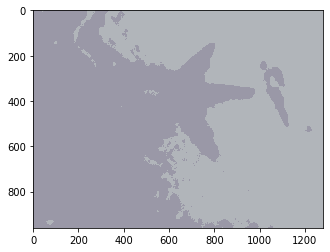

In [12]:
# and convince ourselves its segmenting reasonably well (albeit slowly :-)
            
# Let's (effectively) replace every pixel in the original image
# with the rgb values from the mean of the cluster that pixel
# is now in.
outVec = np.ndarray(shape=(imgWidth * imgHeight, 3), dtype = int)
for index, item in enumerate(tqdm(pixelClusterMembership)):
    outVec[index][0] = int(round(clusterCenters[item][2]))
    outVec[index][1] = int(round(clusterCenters[item][1]))
    outVec[index][2] = int(round(clusterCenters[item][0]))

# Save and display image
img = Image.new("RGB", (imgWidth, imgHeight))

for y in tqdm(range(imgHeight), ascii=True):
    for x in range(imgWidth):
        img.putpixel((x, y), (int(outVec[y*imgWidth + x][0]), int(outVec[y * imgWidth + x][1]), int(outVec[y * imgWidth + x][2])))

#plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)